In [1]:
%matplotlib inline
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [2]:
DATA_DIR = './data/mnist/'

In [3]:
def save_obj(obj, name ):
    with open(DATA_DIR + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(DATA_DIR + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
def readData(images_file, labels_file):
    print(f'reading data file: {images_file}, {labels_file}')
    x = np.loadtxt(DATA_DIR + images_file, delimiter=',')
    y = np.loadtxt(DATA_DIR + labels_file, delimiter=',')
    return x, y

In [5]:
def softmax(x):
    """
    Compute softmax function for input. 
    Use tricks from previous assignment to avoid overflow
    """
    ### YOUR CODE HERE
    if len(x.shape) > 1:
        # Matrix
        tmp = np.max(x, axis=1)
        x -= tmp.reshape((x.shape[0], 1))
        x = np.exp(x)
        tmp = np.sum(x, axis=1)
        x /= tmp.reshape((x.shape[0], 1))
    else:
        # Vector
        tmp = np.max(x)
        x -= tmp
        x = np.exp(x)
        tmp = np.sum(x)
        x /= tmp

    ### END YOUR CODE
    return x

In [2]:
def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    """
    ### YOUR CODE HERE
    pos_mask = (x >= 0)
    neg_mask = ~pos_mask
    s = np.empty_like(x)
    s[pos_mask] = 1 / (1 + np.exp(-x[pos_mask]))
    
    e_x_neg = np.exp(x[neg_mask])
    s[neg_mask] = e_x_neg / (1 + e_x_neg)

    ### END YOUR CODE
    return s

In [7]:
def forward_prop(data, labels, params):
    """
    return hidder layer, output(softmax) layer and loss
    
    data is of shape: B x D
    labels is of shape: B x K
    """
    W1 = params['W1'] # D x H
    b1 = params['b1'] # B x H
    W2 = params['W2'] # H x K
    b2 = params['b2'] # B x K

    ### YOUR CODE HERE
    z1 = data.dot(W1) + b1
    h = sigmoid(z1)
    z2 = h.dot(W2) + b2
    y = softmax(z2)

    loss = - np.multiply(labels, np.log(y + 1e-16)).sum()
    loss /= data.shape[0]
    ### END YOUR CODE
    return h, y, loss

In [30]:
def backward_prop(data, labels, params, use_regularization=False):
    """
    return gradient of parameters
    """
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    ### YOUR CODE HERE
    reg_lambda = 0.0001
    batch_size = labels.shape[0]
    
    a, y_hat, _ = forward_prop(data, labels, params)
    num_hidden_units = a.shape[1]
    
    d_J_softmax = y_hat - labels # (N * 10)
    gradW2 = a.T @ d_J_softmax # (300 x N) * (N x 10) = (300 x 10)
    gradb2 = np.sum(d_J_softmax, axis=0, keepdims=True)
    
    d_a = np.multiply(a,  (1 - a))
    d_J_W2 = d_J_softmax @ (W2.T)
    d_J_W2_d_a = np.multiply(d_J_W2, d_a)

    gradW1 = np.dot(data.T, d_J_W2_d_a)
    gradb1 = np.sum(d_J_W2_d_a, axis=0, keepdims=True)
    # a is (300 x N), d_cost_softmax is 10 X 10
    
    gradW1 /= batch_size
    gradW2 /= batch_size
    gradb1 /= batch_size
    gradb2 /= batch_size
    
    if use_regularization:
        gradW2 += reg_lambda * 2 * W2
        gradW1 += reg_lambda * 2 * W1
    

    ### END YOUR CODE

    grad = {}
    grad['W1'] = gradW1
    grad['W2'] = gradW2
    grad['b1'] = gradb1
    grad['b2'] = gradb2

    return grad

In [24]:
def nn_train(trainData, trainLabels, devData, devLabels, use_regularization=False):
    (m, n) = trainData.shape
    num_hidden = 300
    learning_rate = 5
    params = {}

    ### YOUR CODE HERE
    num_pixels = n
    K = trainLabels.shape[1]
    params['W2'] = np.random.standard_normal((num_hidden, K))
    params['b2'] = np.zeros((1, K), dtype=float)
    
    params['W1'] = np.random.standard_normal((num_pixels, num_hidden))
    params['b1'] = np.zeros((1, num_hidden), dtype=float)
    
    batch_size = 1000
    num_iterations = int(trainData.shape[0] / batch_size)
    epochs = 30
    training_costs = [0.0]*epochs
    dev_costs = [0.0]*epochs
    
    training_accuracies = [0.0]*epochs
    dev_accuracies = [0.0]*epochs
    for i in range(epochs):
        for j in range(num_iterations):
            begin_index = j * batch_size
            end_index = (j + 1) * batch_size
            trainDataSubset = trainData[begin_index:end_index]
            trainLabelSubSet = trainLabels[begin_index:end_index]
            grad_params = backward_prop(trainDataSubset, trainLabelSubSet, params, use_regularization)
            
            # Update parameters

            params['W2'] -= learning_rate * grad_params['W2']
            params['b2'] -= learning_rate * grad_params['b2']
            params['W1'] -= learning_rate * grad_params['W1']
            params['b1'] -= learning_rate * grad_params['b1']
            
        _, y_hat_train, cost_train = forward_prop(trainData, trainLabels, params)
        training_accuracies[i] = compute_accuracy(y_hat_train, trainLabels)
        training_costs[i] = cost_train
        
        _, y_hat_dev, cost_dev = forward_prop(devData, devLabels, params)
        dev_accuracies[i] = compute_accuracy(y_hat_dev, devLabels)
        dev_costs[i] = cost_dev
        
    xs = np.arange(epochs)

    fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12, 4))
    ax0, ax1 = axes.ravel()

    ax0.plot(xs, training_costs, label='train loss')
    ax0.plot(xs, dev_costs, label='dev loss')
    ax0.legend()
    ax0.set_xlabel('# epoch')
    ax0.set_ylabel('CE loss')

    ax1.plot(xs, training_accuracies, label='train acc')
    ax1.plot(xs, dev_accuracies, label='dev acc')
    ax1.legend()
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('Accuracy')
    ### END YOUR CODE
    return params

In [10]:
def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

In [11]:
def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

In [12]:
def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

In [13]:
trainData, trainLabels = readData('images_train.csv', 'labels_train.csv')
trainLabels = one_hot_labels(trainLabels)    

reading data file: images_train.csv, labels_train.csv


In [14]:
testData, testLabels = readData('images_test.csv', 'labels_test.csv')
testLabels = one_hot_labels(testLabels)    

reading data file: images_test.csv, labels_test.csv


In [17]:
def main(trainData, trainLabels, testData, testLabels, use_regularization=False):
    np.random.seed(1000)
    #trainData, trainLabels = readData('images_train.csv', 'labels_train.csv')
    #trainLabels = one_hot_labels(trainLabels)
    p = np.random.permutation(60000)
    trainData = trainData[p,:]
    trainLabels = trainLabels[p,:]

    devData = trainData[0:10000,:]
    devLabels = trainLabels[0:10000,:]
    trainData = trainData[10000:,:]
    trainLabels = trainLabels[10000:,:]

    mean = np.mean(trainData)
    std = np.std(trainData)
    trainData = (trainData - mean) / std
    devData = (devData - mean) / std

    #testData, testLabels = readData('images_test.csv', 'labels_test.csv')
    #testLabels = one_hot_labels(testLabels)
    testData = (testData - mean) / std
    
    params = nn_train(trainData, trainLabels, devData, devLabels, use_regularization)

    file_name = "train_params_without_regularization.pkl"
    if use_regularization:
        file_name = "train_params_with_regularization.pkl"
    save_obj(params, file_name)

    readyForTesting = True
    if readyForTesting:
        accuracy = nn_test(testData, testLabels, params)
        print('Test accuracy: %f' % accuracy)

Test accuracy: 0.932100


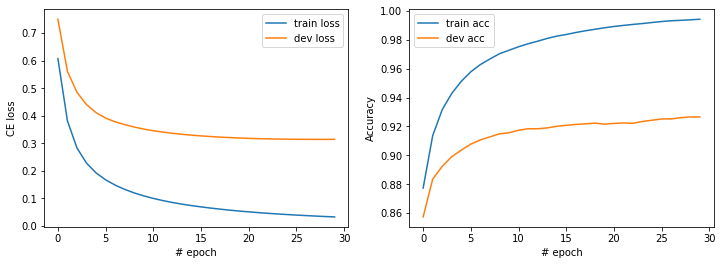

In [28]:
if __name__ == '__main__':
    main(trainData, trainLabels, testData, testLabels, use_regularization=False)

Test accuracy: 0.967700


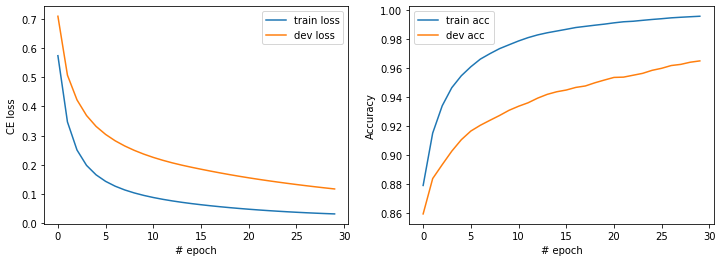

In [31]:
if __name__ == '__main__':
    main(trainData, trainLabels, testData, testLabels, use_regularization=True)